In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from catboost import CatBoostClassifier, Pool
import shap

df = pd.read_csv("Airlines.csv")
df.head()


,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


In [4]:
df.describe(include='all')

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
count,539383.000000,539383,539383.000000,539383,539383,539383.000000,539383.000000,539383.000000,539383.000000
unique,NaN,18,NaN,293,293,NaN,NaN,NaN,NaN
top,NaN,WN,NaN,ATL,ATL,NaN,NaN,NaN,NaN
freq,NaN,94097,NaN,34449,34440,NaN,NaN,NaN,NaN
mean,269692.000000,NaN,2427.928630,NaN,NaN,3.929668,802.728963,132.202007,0.445442
std,155706.604461,NaN,2067.429837,NaN,NaN,1.914664,278.045911,70.117016,0.497015
min,1.000000,NaN,1.000000,NaN,NaN,1.000000,10.000000,0.000000,0.000000
25%,134846.500000,NaN,712.000000,NaN,NaN,2.000000,565.000000,81.000000,0.000000
50%,269692.000000,NaN,1809.000000,NaN,NaN,4.000000,795.000000,115.000000,0.000000
75%,404537.500000,NaN,3745.000000,NaN,NaN,5.000000,1035.000000,162.000000,1.000000


In [5]:
df.duplicated().sum()

0

In [6]:
df[df['Time']>1035].describe(include='all')

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
count,132650.000000,132650,132650.000000,132650,132650,132650.000000,132650.000000,132650.000000,132650.000000
unique,NaN,18,NaN,232,265,NaN,NaN,NaN,NaN
top,NaN,WN,NaN,ATL,ATL,NaN,NaN,NaN,NaN
freq,NaN,22740,NaN,11346,6046,NaN,NaN,NaN,NaN
mean,276148.197467,NaN,2339.932733,NaN,NaN,3.900686,1169.347629,131.874354,0.516216
std,154984.951131,NaN,2064.340269,NaN,NaN,1.930085,91.002774,73.149440,0.499739
min,13191.000000,NaN,1.000000,NaN,NaN,1.000000,1036.000000,0.000000,0.000000
25%,137263.250000,NaN,657.000000,NaN,NaN,2.000000,1095.000000,80.000000,0.000000
50%,275083.500000,NaN,1704.000000,NaN,NaN,4.000000,1155.000000,114.000000,1.000000
75%,402075.750000,NaN,3484.000000,NaN,NaN,5.000000,1230.000000,160.000000,1.000000


<Axes: >

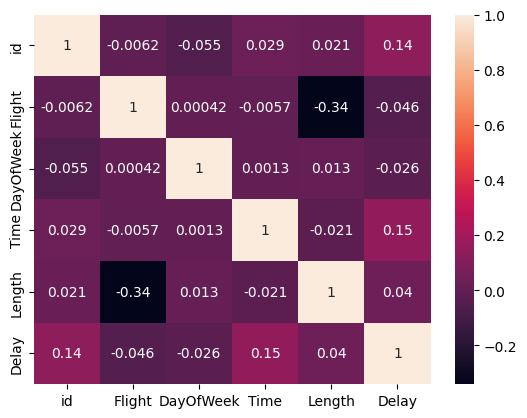

In [7]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [9]:
df['DayOfWeek'].describe()

count    539383.000000
mean          3.929668
std           1.914664
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           7.000000
Name: DayOfWeek, dtype: float64

In [10]:
df['is_weekend'] = df['DayOfWeek'].isin([0,7]).astype(int)
print(df['is_weekend'])

0         0
1         0
2         0
3         0
4         0
         ..
539378    0
539379    0
539380    0
539381    0
539382    0
Name: is_weekend, Length: 539383, dtype: int32


In [11]:
df['is_weekend'].describe()

count    539383.000000
mean          0.129554
std           0.335812
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_weekend, dtype: float64

In [14]:
df[df['is_weekend']==1].shape

(69879, 10)

In [13]:
df[df['is_weekend']==1]['Delay'].value_counts()

Delay
0    38186
1    31693
Name: count, dtype: int64

In [16]:
df['hour_duration']=df['Time']/60
df

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,is_weekend,hour_duration
0,1,CO,269,SFO,IAH,3,15,205,1,0,0.250000
1,2,US,1558,PHX,CLT,3,15,222,1,0,0.250000
2,3,AA,2400,LAX,DFW,3,20,165,1,0,0.333333
3,4,AA,2466,SFO,DFW,3,20,195,1,0,0.333333
4,5,AS,108,ANC,SEA,3,30,202,0,0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0,0,23.983333
539379,539380,FL,398,SEA,ATL,5,1439,305,0,0,23.983333
539380,539381,FL,609,SFO,MKE,5,1439,255,0,0,23.983333
539381,539382,UA,78,HNL,SFO,5,1439,313,1,0,23.983333


In [17]:
df = df.drop(columns=['id'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Airline        539383 non-null  object 
 1   Flight         539383 non-null  int64  
 2   AirportFrom    539383 non-null  object 
 3   AirportTo      539383 non-null  object 
 4   DayOfWeek      539383 non-null  int64  
 5   Time           539383 non-null  int64  
 6   Length         539383 non-null  int64  
 7   Delay          539383 non-null  int64  
 8   is_weekend     539383 non-null  int32  
 9   hour_duration  539383 non-null  float64
dtypes: float64(1), int32(1), int64(5), object(3)
memory usage: 39.1+ MB


# Modelagem

In [19]:
X = df.drop(columns=['Delay'])
y = df['Delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
cat_features = ['Airline', 'AirportFrom', 'AirportTo']
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [20]:
train_pool

In [21]:
model = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, loss_function="Logloss", verbose=False)
model.fit(train_pool, eval_set=test_pool, verbose=False)


In [22]:
pred = model.predict(test_pool)
print("Accuracy", accuracy_score(y_test, pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, pred))

Accuracy 0.6659250813426403
Confusion matrix:
[[48082 11742]
 [24297 23756]]


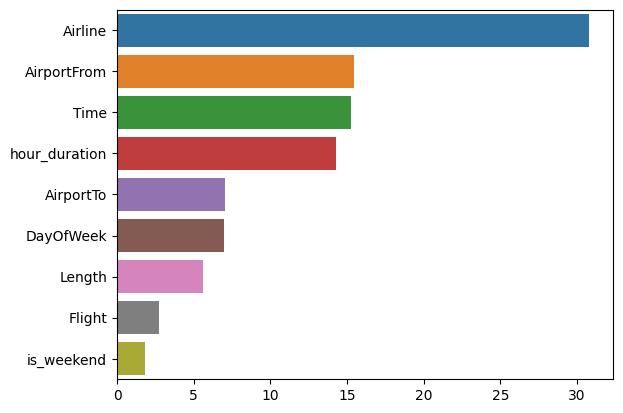

In [24]:
imp = pd.Series(model.get_feature_importance(test_pool), index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=imp.values, y=imp.index)
plt.show()

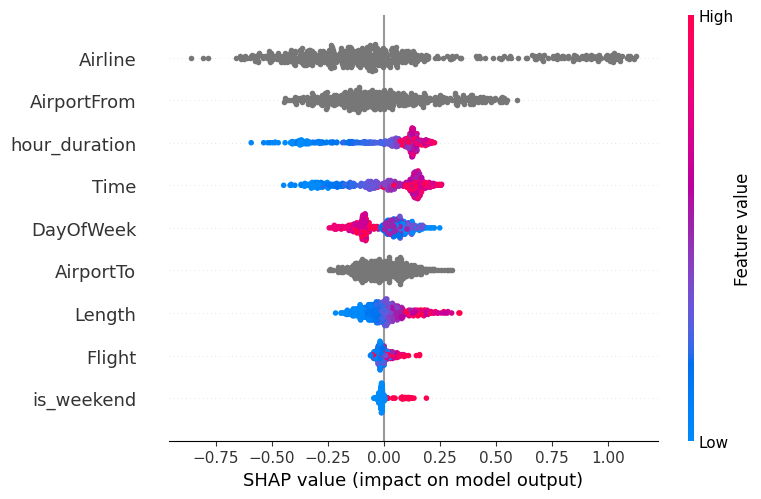

In [25]:
sample_idx = np.random.RandomState(42).choice(len(X_test), size=500, replace=False)
X_shap = X_test.iloc[sample_idx]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap)

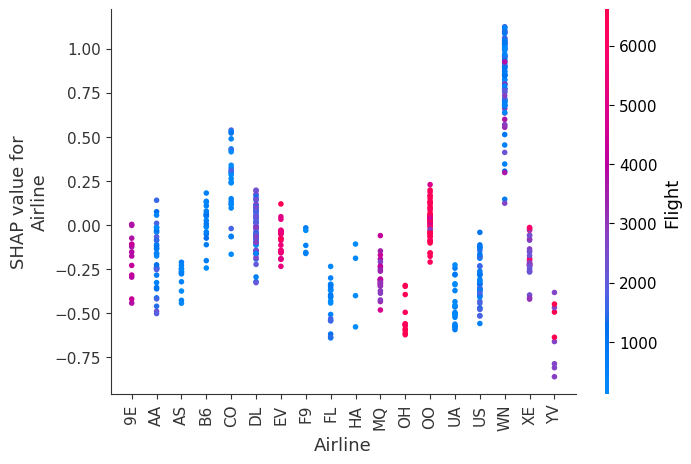

In [26]:
for c in X_shap.columns:
    if X_shap[c].dtype== 'object':
        shap.dependence_plot(c, shap_values, X_shap)
        break